### Генерация аниме изображений

Будем использовать Anime Face Dataset от Mckinsey666, который содержит 63 632 обрезанных изображения. Размеры изображений варьируются от 90х90 - 120х120.

In [ ]:
import opendatasets as od
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.utils import save_image
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

#### Загрузка и изучение данных

In [ ]:
dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tatyanastrizhakova
Your Kaggle Key: ··········


100%|██████████| 395M/395M [00:09<00:00, 44.6MB/s]


In [ ]:
data_dir = './animefacedataset'
print(os.listdir(data_dir))

['images']


In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder(data_dir, transform=T.Compose([T.Resize(image_size),
                                                      T.CenterCrop(image_size),
                                                      T.ToTensor(),
                                                      T.Normalize(*stats)]))
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

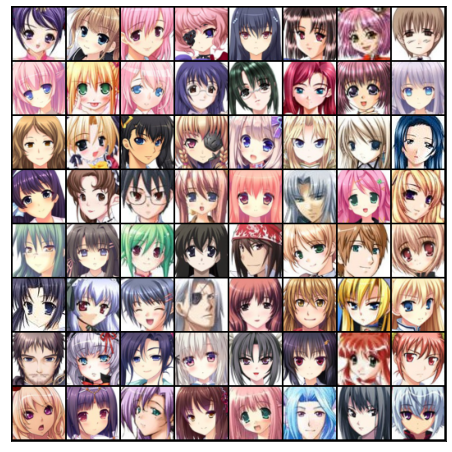

In [ ]:
show_batch(train_dl)

#### Использование GPU

In [ ]:
def get_default_device():
    '''Выбирает GPU если он доступен, иначе CPU'''
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    '''Перемещает тензор на выбранное устройство'''
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    '''Загрузчик для перемещения данных на устройство'''
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        '''Выдает пакет данных после их перемещения на устройство'''
        for i in self.dl:
            yield to_device(i, self.device)
            
    def __len__(self):
        '''Возвращает количество пакетов'''
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

#### Discriminator Network

Будем использовать сверточные нейронные сети, которые выводят одно число для каждого изображения. Мы будем использовать stride = 2, чтобы постепенно уменьшать размер выходной карты объектов.

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64
    
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16
    
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8
    
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4
    
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1
    
    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

#### Generator Network

Для преобразования тензора в форму 3х28х28 будем использовать слой nn.ConvTranspose2d из PyTorch.
В качестве функции активации применим TanH для выходного слоя генератора.

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1
    
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4
    
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8
    
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32
    
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3x 64 x 64
)

torch.Size([128, 3, 64, 64])


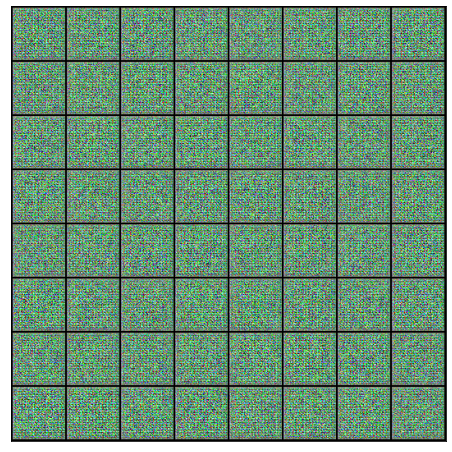

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

#### Обучение дискриминатора

Так как дискриминатор — модель двоичной классификации, мы можем использовать функцию потери двоичной перекрестной энтропии для количественной оценки того, насколько хорошо он способен различать реальные и сгенерированные изображения.

In [ ]:
def train_discriminator(real_images, opt_d):
    # Обнуление градиентов
    opt_d.zero_grad()
    
    # Подача реальных изображений
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Генерация фейковых изображений
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Подача фейковых изображений
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    
    # Обновление весов
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

#### Обучение генератора

In [ ]:
def train_generator(opt_g):
    # Обнуление градиентов
    opt_g.zero_grad()
    
    # Генерация фейковых изображений
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Попытка обмануть дискриминатор
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Обновление весов
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [ ]:
sample_dir = 'generated'
os.makedirs('generated', exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors,show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated_images_{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated_images_0000.png


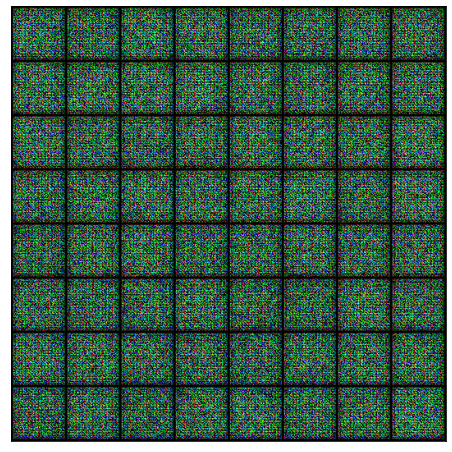

In [ ]:
save_samples(0, fixed_latent)

#### Полный цикл обучения

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            loss_g = train_generator(opt_g)
            
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        print('Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}'.format(
            epoch + 1, epochs, loss_g, loss_d, real_score, fake_score))
        
        save_samples(epoch + start_idx, fixed_latent, show=False)
        
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 25

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 10.8023, loss_d: 1.8527, real_score: 0.9313, fake_score: 0.7837
Saving generated_images_0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 5.9109, loss_d: 0.4254, real_score: 0.9009, fake_score: 0.2512
Saving generated_images_0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 4.5570, loss_d: 0.4301, real_score: 0.8869, fake_score: 0.2433
Saving generated_images_0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 3.4143, loss_d: 0.5030, real_score: 0.6849, fake_score: 0.0284
Saving generated_images_0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 10.0169, loss_d: 0.5561, real_score: 0.9553, fake_score: 0.3695
Saving generated_images_0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 6.0475, loss_d: 0.1416, real_score: 0.8948, fake_score: 0.0159
Saving generated_images_0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 7.5404, loss_d: 0.4009, real_score: 0.7305, fake_score: 0.0016
Saving generated_images_0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 4.5531, loss_d: 0.2195, real_score: 0.8910, fake_score: 0.0814
Saving generated_images_0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 4.7791, loss_d: 0.1627, real_score: 0.9418, fake_score: 0.0890
Saving generated_images_0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 5.1365, loss_d: 0.1170, real_score: 0.9115, fake_score: 0.0154
Saving generated_images_0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 4.3353, loss_d: 0.2126, real_score: 0.8715, fake_score: 0.0545
Saving generated_images_0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 2.5145, loss_d: 0.2414, real_score: 0.8406, fake_score: 0.0358
Saving generated_images_0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 4.2499, loss_d: 0.2549, real_score: 0.9079, fake_score: 0.1204
Saving generated_images_0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 4.2520, loss_d: 0.1714, real_score: 0.9232, fake_score: 0.0776
Saving generated_images_0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 3.2693, loss_d: 0.2504, real_score: 0.8684, fake_score: 0.0668
Saving generated_images_0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 3.2310, loss_d: 0.1975, real_score: 0.8773, fake_score: 0.0317
Saving generated_images_0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 4.2491, loss_d: 0.0941, real_score: 0.9591, fake_score: 0.0474
Saving generated_images_0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 5.2466, loss_d: 0.1916, real_score: 0.9618, fake_score: 0.1210
Saving generated_images_0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 9.3637, loss_d: 0.8073, real_score: 0.9981, fake_score: 0.4752
Saving generated_images_0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 4.0761, loss_d: 0.1276, real_score: 0.9187, fake_score: 0.0243
Saving generated_images_0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 6.0479, loss_d: 0.1174, real_score: 0.9908, fake_score: 0.0952
Saving generated_images_0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 4.9439, loss_d: 0.0683, real_score: 0.9813, fake_score: 0.0466
Saving generated_images_0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 5.7760, loss_d: 0.3252, real_score: 0.9445, fake_score: 0.2059
Saving generated_images_0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 2.8712, loss_d: 0.1561, real_score: 0.8908, fake_score: 0.0223
Saving generated_images_0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 5.7451, loss_d: 0.2251, real_score: 0.9758, fake_score: 0.1548
Saving generated_images_0025.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

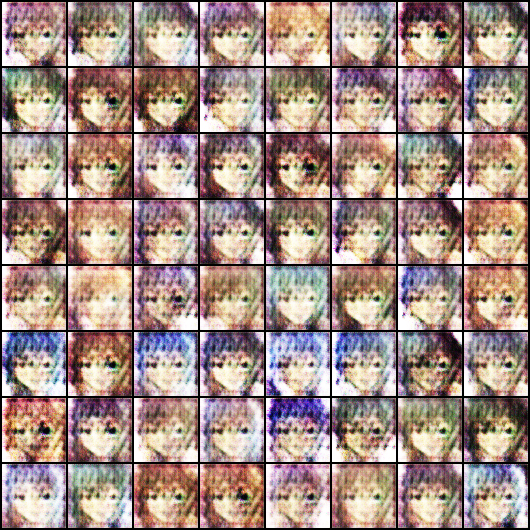

In [ ]:
Image('generated/generated_images_0001.png')

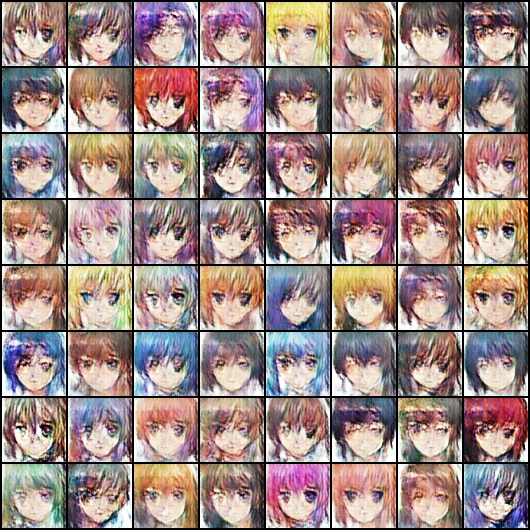

In [ ]:
Image('generated/generated_images_0005.png')

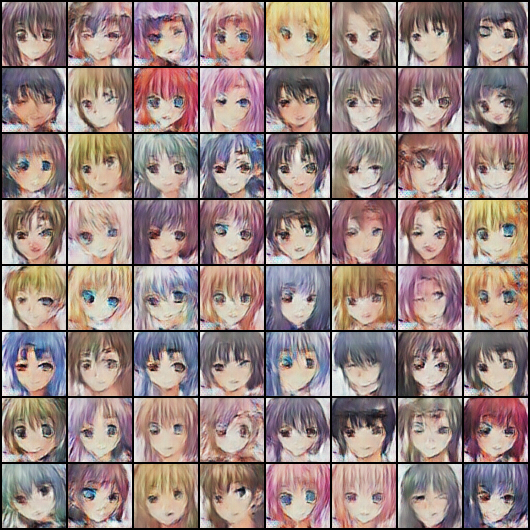

In [ ]:
Image('generated/generated_images_0010.png')

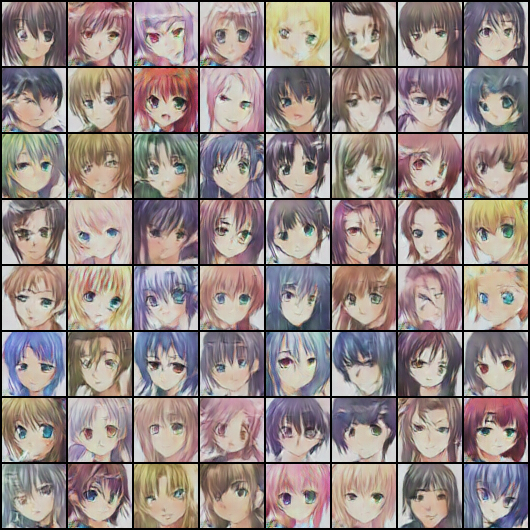

In [ ]:
Image('generated/generated_images_0020.png')

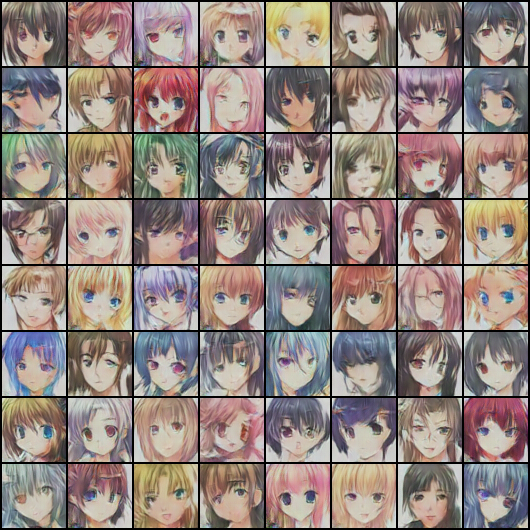

In [ ]:
Image('generated/generated_images_0025.png')

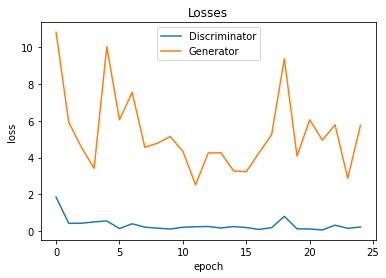

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

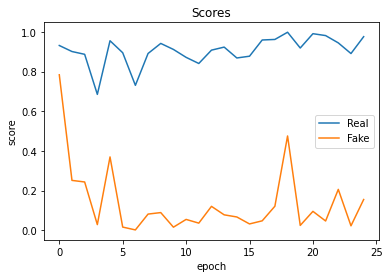

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

Мы ожидаем, что потери генератора со временем уменьшатся, при этом потери дискриминатора не станут слишком высокими.